## Стратегии исследования в Q-обучении

В этой тетрадке воспользуемся ранее реализованным алгоритмом Q-обучения и адаптируем алгоритмы исследования из тетрадки по бандитам, чтобы посмотреть, насколько наблюдаемые результаты переносятся в MDP-постановку.

Для обучения будем использовать среды [Taxi-v3](https://gymnasium.farama.org/environments/toy_text/taxi/) и [Boulder](https://sites.google.com/view/edu-gym/environments/bouldering?authuser=0).

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from numpy.random import Generator
from IPython.display import clear_output

%matplotlib inline

In [3]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.plot(log, label='Avg returns')
    plt.legend(loc=4)
    plt.show()

Ниже адаптируйте заготовку, взятую из тетради с бандитами, под алгоритм Q-обучения. Как и в том задании, реализация агента будет поддерживать одновременно все возможныые стратегии исследования. Выбор происходит по тому, какие из гиперпараметров активны:
- если `random() < eps * decay`, действие выбирается случайно (для случайной, eps-жадной и eps-жадной с затуханием), иначе
- если `softmax_t_inv > 0`, выбор производится по softmax с `t_inv = softmax_t_inv * T_decay ^ softmax_t_decay` обратной температурой (softmax стратегия)
- иначе выбираем жадно на основе значений `Q[s, a] + u[a]`, где `u`:
  - вычисляется по UCB, если `ucb_const > 0` (UCB стратегия),
  - иначе берется `u = 0` (жадная, вторая часть eps-жадной и eps-жадной с затуханием)

(2 балла)

In [4]:
def softmax(xs, inv_temp=1.):
    exp_xs = np.exp((xs - xs.max()) * inv_temp)
    return exp_xs / exp_xs.sum()

class Agent:
    # Реализует агента с Q-обучением и разными вариантами
    # исследовательской стратегии: eps-greedy, eps-greedy with decay, ucb1, softmax
    eps: float
    eps_decay: float
    exp_const: float

    # Q-функция
    Q: npt.NDArray
    # счетчик посещений пар (состояние, действие)
    n: npt.NDArray
    T: float
    rng: Generator

    def __init__(
        self, name, n_states, n_actions, *, seed,
        lr, gamma,
        eps=0., eps_decay=1.,
        ucb_const=0.,
        softmax_t_inv=0., softmax_t_decay=0.,
    ):
        self.name = name
        self.eps = eps
        self.eps_decay = eps_decay
        self.ucb_const = ucb_const
        self.softmax_t_inv = softmax_t_inv
        self.softmax_t_decay = softmax_t_decay

        self.lr = lr
        self.gamma = gamma

        self.Q = np.zeros((n_states, n_actions))
        self.n = np.ones_like(self.Q)
        self.T = np.prod(self.n.shape)
        self.T_decay = 0

        self.rng = np.random.default_rng(seed)

    def update(self, s, a, r, next_s, done):
        lr, gamma = self.lr, self.gamma
        # посчитай TD ошибку и обновите Q-функцию
        # td_error =
        ####### Здесь ваш код ########
        td_error = (r + gamma * self.Q[next_s, :].max()) - self.Q[s, a]
        self.Q[s, a] += lr * td_error
        ##############################

    def _update_visitations(self, s, a):
        # Update visitations
        ####### Здесь ваш код ########
        self.n[s, a] += 1
        ##############################

    def act(self, state):
        rng = self.rng
        s, Q, n, T_decay = state, self.Q, self.n, self.T_decay
        n_actions = Q.shape[-1]

        # Implement action selection:
        #   a) if eps > 0 then random with probability eps
        #   b) if softmax_t_inv > 0 then softmax
        #   b) else greedy action selection:
        #       if ucb_const > 0, using UCB estimate for Q[s,a]
        #       else using Q[s,a] estimate
        # action =
        ####### Здесь ваш код ########
        values = self.Q[s, :].flatten()
        actions = np.arange(Q.shape[1])
        if self.eps > 0:
            prob = rng.random()
            if prob < self.eps * self.eps_decay ** T_decay:
                action = rng.choice(actions)
            else:
                action = np.argmax(values)
        elif self.softmax_t_inv > 0:
            dist = softmax(values, inv_temp=self.softmax_t_inv * self.softmax_t_decay ** T_decay)
            action = np.random.choice(actions, p=dist)
        else:
            if self.ucb_const > 0 and T_decay > 0:
                action = np.argmax(values + np.sqrt(self.ucb_const * np.log(T_decay) / self.n[s, :]))
            else:
                action = np.argmax(values)
        ##############################

        self._update_visitations(s, action)
        return action

    def decay_eps(self):
        self.T_decay += 1

    @property
    def exploration_param(self):
        # for debug purposes return current exploration param:
        # Для eps-жадной: eps * decay, Softmax: t_inv, UCB: u (на основе self.n.mean())
        ####### Здесь ваш код ########
        if self.eps > 0:
            return self.eps * self.eps_decay ** self.T_decay
        elif self.softmax_t_inv > 0:
            return self.softmax_t_inv * self.softmax_t_decay ** self.T_decay
        elif self.ucb_const > 0 and self.T_decay > 0:
            return np.sqrt(self.ucb_const * np.log(self.T_decay) / self.n.mean())
        ##############################
        return 0.

(1 балл)

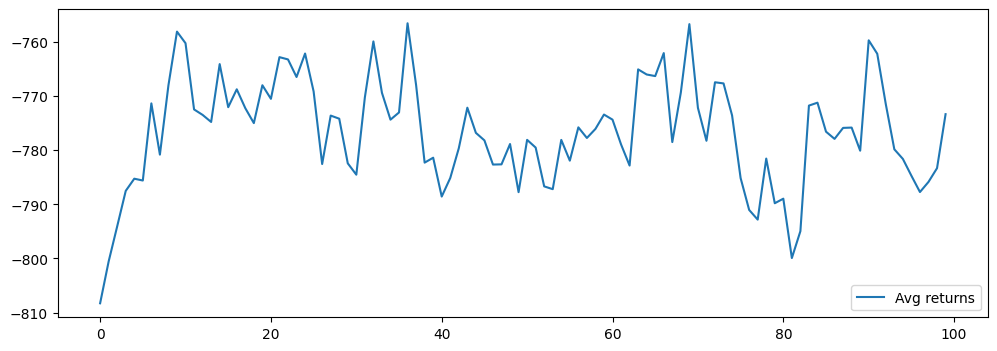

[softmax] Step: 500000, Episode: 2534, Return: -773.35, Exploration: 0.0


In [5]:
seed = 41
env = gym.make('Taxi-v3', max_episode_steps=200)

n_states, n_actions = env.observation_space.n, env.action_space.n

# гиперпараметры алгоритма
lr = 0.02
gamma = 0.97
eps_decay, ucb_const = .998, 2.
softmax_t_inv, softmax_t_decay=0.2, 0.6
n_steps, schedule = 500_000, 5_000

agent_random = Agent('rand', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.)
agent_eps_greedy25 = Agent('eps-greedy_0.25', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.25)
agent_eps_greedy5 = Agent('eps-greedy_0.05', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.05)
agent_eps_greedy_decayed = Agent('eps-greedy-dec', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.0, eps_decay=eps_decay)
agent_ucb = Agent('ucb', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, ucb_const=ucb_const)
agent_softmax = Agent('softmax', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, softmax_t_inv=softmax_t_inv, softmax_t_decay=softmax_t_decay)

agents = [
    # agent_random,
    agent_eps_greedy25,
    agent_eps_greedy5,
    agent_eps_greedy_decayed,
    agent_ucb,
    agent_softmax,
]

log = []
for agent in agents:
    log.append([])
    agent_returns = None
    step, ep = 0, 1
    while step < n_steps:
        s, _ = env.reset()
        ep_ret = 0
        done = False
        while not done:
            # реализуйте цикл взаимодействия со средой в рамках эпизода
            ####### Здесь ваш код ########
            a = agent.act(s)
            next_s, reward, terminated, truncated, info = env.step(a)

            s = next_s
            ep_ret += reward
            done = terminated or truncated
            step += 1
            ##############################

            if step % schedule == 0 and agent_returns:
                show_progress(agent_returns, log[-1])
                print(f"[{agent.name}] Step: {step}, Episode: {ep}, Return: {agent_returns:.2f}, Exploration: {agent.exploration_param}")

        ep += 1
        agent.decay_eps()
        if agent_returns is None:
            agent_returns = ep_ret
        # делаем экспоненциальное сглаживание графика
        agent_returns += 0.02 * (ep_ret - agent_returns)

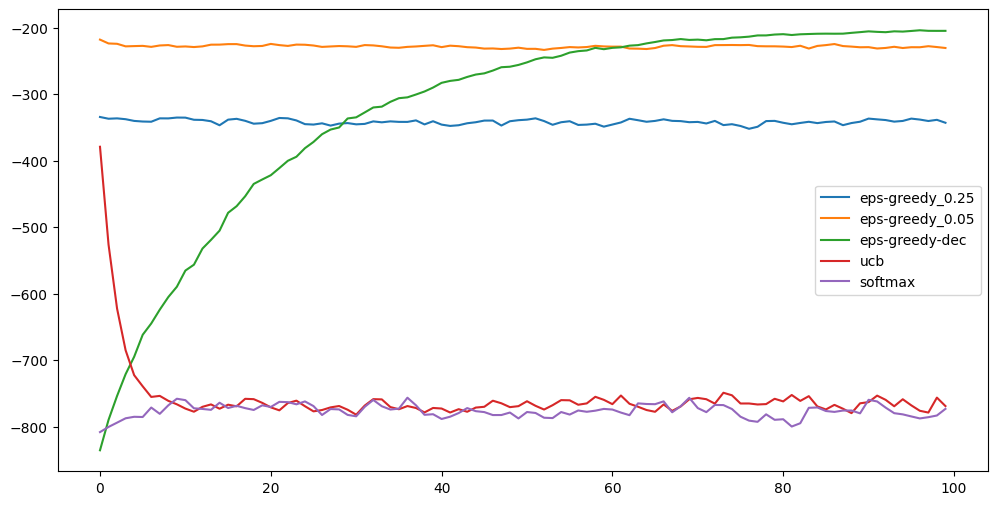

In [6]:
# Compare results
plt.figure(figsize=[12, 6])
for agent_log in log:
    _ = plt.plot(agent_log)
plt.legend([agent.name for agent in agents])

(1 балл)

**Вопросы**: Что можно сказать о динамике исследования агентом? Какие из исследовательских стратегий более универсальны с точки зрения подбора гиперпараметров под среду?

eps-методы лучше исследуют среду. Затухающий eps-метод (зеленая линия), при подобранной скорости затухания, хорошо справляется с тем, чтобы улучшать политику. Однако, это в контексте Taxi-v3, где средняя длина эпизода совсем небольшая ($\approx 20$), мы получаем награду быстро (сигнал в конце каждого эпизода, эпизоды короткие $\implies$ TD-сигнал частый $\implies$ Q-значения быстро протекают), и рандом находит хорошие траектории. Также, из-за того, что здесь $\approx 500$ состояний, то методы, которые мало исследуют, вообще не находят оптимум (что видно про UCB/softmax).

Думаю, затухающий eps-метод наиболее универсальный, чем константные eps-методы для такой среды, так как в конце обучения мы хотим отказаться от исследования и начать жадно применять политику.

В UCB/Softmax, спустя $10-20$ посещений каждой пары $(s, a)$, мы уже действуем практически жадно $\implies$ мало исследуем.

### Bouldering

Давайте попробуем проверить реализованные алгоритмы в среде Boulder, которая требует от агента выполнить определенную последовательность действий (при выборе неверного действия в состоянии, он "падает" в начало, эпизод при этом продолжается). Сложность среды определяется высотой (=число состояний) и шириной трассы (=число действий).

Для отладки, имеет смысл взять сначала небольшие значения (например, h=3, w=2) и постепенно увеличивать их.

In [7]:
from gymnasium import spaces

class BoulderEnv(gym.Env):
    metadata = {"render_modes": ["terminal", "human"]}
    def __init__(self, render_mode=None, height=10, n_grips=2, max_steps=1000, success_prob=0.0):
        '''
        |- |
        |- |   '-': grip
        | -|   '*': agent
        | -|
        _*__
        '''
        self.height = height
        self.n_grips = n_grips
        self.max_steps = max_steps
        self.steps_taken = 0
        self.success_prob = success_prob

        # Observation is the current height of the agent.
        self.observation_space = spaces.Discrete(self.height+1)

        # We have n_grips actions, every time the agent needs to grip the right grips
        self.action_space = spaces.Discrete(self.n_grips)

        self.pygame_initialized = False

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.reset()

    def _get_initial_loc(self):
        return 0

    def _get_obs(self):
        return self._agent_location

    def render(self):
        pass

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Initialize positions of grips
        self._agent_location = self._get_initial_loc()
        self.grips = self.np_random.choice(self.n_grips, self.height)
        self.steps_taken = 0

        observation = self._get_obs()

        return observation, {}

    def step(self, action):
        # if the action match the given grip
        if action == self.grips[self._agent_location]:
            self._agent_location += 1
        elif self.np_random.random() < self.success_prob:
            # got lucky
            self._agent_location += 1
        else:
            self._agent_location = self._get_initial_loc()

        if self._agent_location == self.height:
            # print("REACHED THE TARGET")
            reward = 1
            terminated = True
            truncated = False
        else:
            reward = 0
            terminated = False
            truncated = False

        self.steps_taken += 1

        if self.steps_taken == self.max_steps:
            # print("MAX STEPS IS REACHED")
            terminated = False
            truncated = True

        observation = self._get_obs()

        return observation, reward, terminated, truncated, {}

gym.register(
    id=f"Boulder-v0",
    entry_point="__main__:BoulderEnv",
)

In [8]:
env = gym.make("Boulder-v0")
env.reset()

(0, {})

(1 балл)

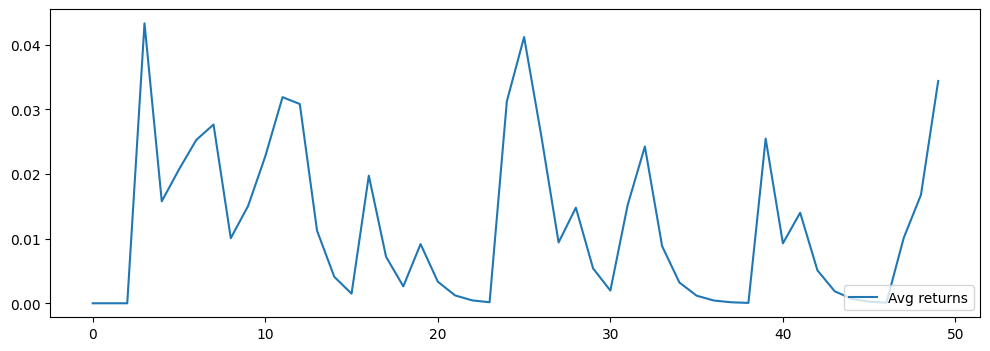

[softmax] Step: 500000, Episode: 2516, Return: 0.03, Exploration: 0.0


In [9]:
seed = 41
env = gym.make('Boulder-v0', height=7, n_grips=4, success_prob=0.05, max_episode_steps=200)

n_states, n_actions = env.observation_space.n, env.action_space.n

# гиперпараметры алгоритма
lr = 0.02
gamma = 0.98
eps_decay, ucb_const = .9992, 2.
softmax_t_inv, softmax_t_decay=0.2, 0.6
n_steps, schedule = 500_000, 10_000

agent_random = Agent('rand', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.)
agent_eps_greedy25 = Agent('eps-greedy_0.25', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.25)
agent_eps_greedy5 = Agent('eps-greedy_0.05', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=0.05)
agent_eps_greedy_decayed = Agent('eps-greedy-dec', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, eps=1.0, eps_decay=eps_decay)
agent_ucb = Agent('ucb', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, ucb_const=ucb_const)
agent_softmax = Agent('softmax', n_states, n_actions, seed=seed, lr=lr, gamma=gamma, softmax_t_inv=softmax_t_inv, softmax_t_decay=softmax_t_decay)

agents = [
    # agent_random,
    agent_eps_greedy25,
    agent_eps_greedy5,
    agent_eps_greedy_decayed,
    agent_ucb,
    agent_softmax,
]

log = []
for agent in agents:
    log.append([])
    agent_returns = None
    step, ep = 0, 1
    while step < n_steps:
        s, _ = env.reset(seed=seed)
        ep_ret = 0
        done = False
        while not done:
            # реализуйте цикл взаимодействия со средой в рамках эпизода
            ####### Здесь ваш код ########
            a = agent.act(s)
            next_s, reward, terminated, truncated, info = env.step(a)

            s = next_s
            ep_ret += reward
            done = terminated or truncated
            step += 1
            ##############################

            if step % schedule == 0:
                show_progress(agent_returns, log[-1])
                print(f"[{agent.name}] Step: {step}, Episode: {ep}, Return: {agent_returns:.2f}, Exploration: {agent.exploration_param}")

        ep += 1
        agent.decay_eps()
        if agent_returns is None:
            agent_returns = ep_ret
        agent_returns += 0.02 * (ep_ret - agent_returns)

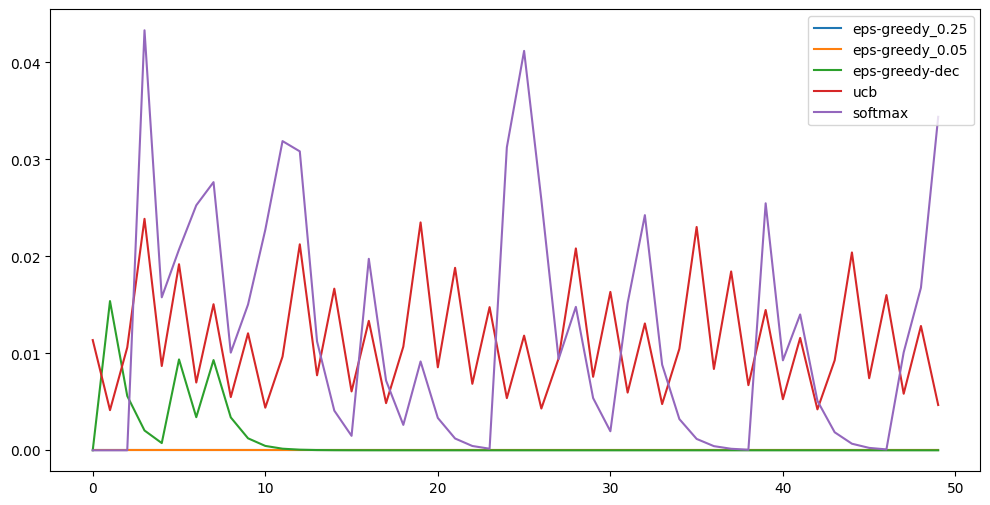

In [10]:
# Compare results
plt.figure(figsize=[12, 6])
for agent_log in log:
    _ = plt.plot(agent_log)
plt.legend([agent.name for agent in agents])

(1 балл)

**Вопросы**: Почему стратегии с константной eps-жадностью сильно деградируют с ростом сложности задачи?

В Bouldering, в отличии от Taxi-v3, длина эпизодов может быть $1000+$ шагов. Константный рандом приводит к тому, что из $1000$ шагов мы можем делать $\approx 50$ шагов полностью случайно (для $\varepsilon = 0.05$). В сложной среде, при неконтролируемом постоянном исследовании, где один шаг может сильно увести в сторону, константная eps-стратегия деградирует.

UCB/Softmax/затухающий eps-метод находят субоптимальное решение, которое далеко не идеальное, но лучше чем константные eps-методы. Они, из-за постоянного рандома, уходят в плохие траектории и долго плутают без сигнала.